# ДЗ №1
Распознать изображение с игральными картами и вывести изображение и номинал каждой карты

(749, 700, 4)


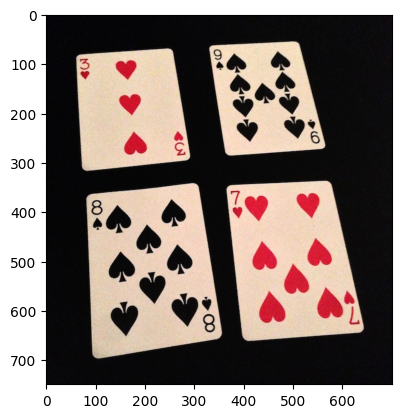

In [5]:
import cv2
import matplotlib.pyplot as plt
from skimage.io import imread
import numpy as np

img = imread('http://farm4.staticflickr.com/3828/9060450367_b67ef44444_o_d.png')

print(img.shape)

plt.imshow(img)
plt.show()

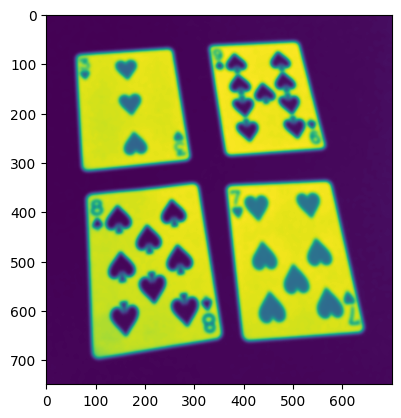

In [13]:
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) # Основная команда - в оттенки серого
blur = cv2.GaussianBlur(gray, (21, 21), 0) # !!! ПОДОБРАТЬ ЗНАЧЕНИЯ ПАРАМЕТРОВ ВМЕCТО ТОЧЕК
plt.imshow(blur)
plt.show()

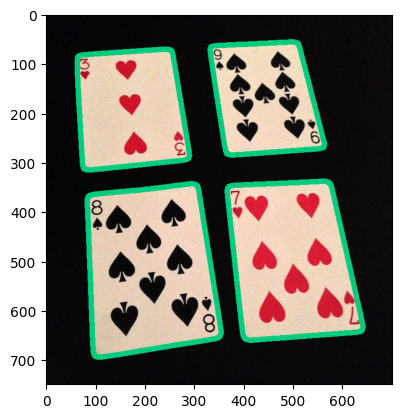

In [20]:
numcards = 4

flag, thresh = cv2.threshold(blur, 128, 255,  cv2.THRESH_BINARY) # !!! ПОДОБРАТЬ ЗНАЧЕНИЯ ПАРАМЕТРОВ ВМЕCТО ТОЧЕК
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
contours = sorted(contours, key=cv2.contourArea, reverse=True)[:numcards] # !!! ВСТАВИТЬ КОД ВМЕСТО ТОЧЕК

contours_img = img.copy()
cv2.drawContours(contours_img, contours, contourIdx = -1, color = (0, 204, 128, 255), thickness = 10)  
plt.imshow(contours_img)
plt.show()

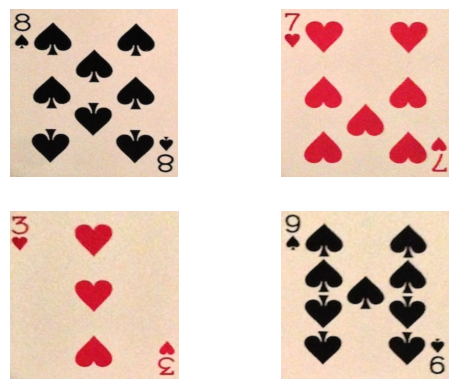

In [29]:
for i in range(numcards):
    card = contours[i]
    peri = cv2.arcLength(card,True)
    approx = np.array(cv2.approxPolyDP(card,0.02*peri,True), np.float32)
    rect = cv2.minAreaRect(contours[2])
    r = cv2.boxPoints(rect)
    h = np.array([[0,0],[450,0],[450,450],[0,450]], np.float32) # !!! ПОДОБРАТЬ ЗНАЧЕНИЯ ПАРАМЕТРОВ ВМЕCТО ТОЧЕК
    transform = cv2.getPerspectiveTransform(approx,h)
    warp = cv2.warpPerspective(img,transform,(450,450))[:,::-1]
    plt.subplot(2,2,i+1); plt.axis('off')   
    plt.imshow(warp)

plt.show()

9


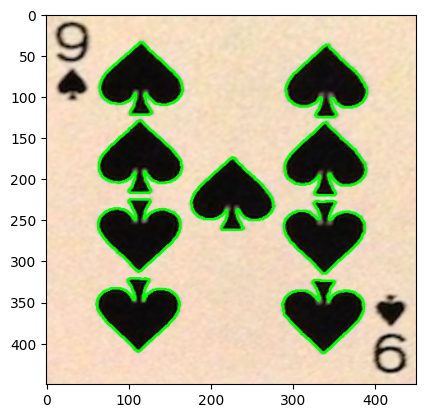

In [65]:
img_gray = cv2.cvtColor(warp,cv2.COLOR_RGB2GRAY)
contours_img = warp.copy()

flag, thresh = cv2.threshold(img_gray, 128, 255, cv2.THRESH_BINARY) # !!!
contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)
contours = sorted(contours, key=cv2.contourArea, reverse=True) # все контуры на карте

main_contours = []
main_area = 0
for contour in contours:
  # скипаем огромные контуры - они нам не нужны
  if cv2.contourArea(contour) > .9*warp.shape[0]*warp.shape[1]: continue

  # базовая площадь значка масти
  if main_area == 0:
    main_contours.append(contour)
    main_area = cv2.contourArea(contour)
  else:
    if cv2.contourArea(contour) > .9*main_area : 
      main_contours.append(contour)
print(len(main_contours))

cv2.drawContours(contours_img, main_contours, contourIdx = -1, color = (0, 255, 0, 255), thickness = 2)
plt.imshow(contours_img)
plt.show()

1) Условный оператор (if) используется для отсеивания неподходящих контуров.

2) `cv2.contourArea(contour)` - это функция библиотеки OpenCV, которая вычисляет площадь замкнутого контура. В данном случае, это контур, определенный функцией findContours.

3) `warp.shape[0]*warp.shape[1]` - это произведение высоты и ширины образа warp. В данном случае, это обработанное изображение, на котором был выполнен определенный метод, например, сегментация изображения.

4) Функция `findContours` находит все контуры в бинарном изображении, и условие `cv2.contourArea(contour) > .9*warp.shape[0]*warp.shape[1]` позволяет отсеять контуры, площадь которых меньше 90% площади образа.

Таким образом, код отсеивает контуры, площадь которых меньше 90% площади образа, что улучшает результаты дальнейшей обработки.

## Соберём всё вместе

In [88]:
def show_image(img, title):
    plt.axis('off') 
    plt.title(label=title)
    plt.imshow(img)
    plt.show()


def identify_card(warp):
    img_gray = cv2.cvtColor(warp,cv2.COLOR_RGB2GRAY)
    contours_img = warp.copy()

    flag, thresh = cv2.threshold(img_gray, 128, 255, cv2.THRESH_BINARY) # !!!
    contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True) # все контуры на карте

    main_contours = []
    main_area = 0
    for contour in contours:
        # скипаем огромные контуры - они нам не нужны
        if cv2.contourArea(contour) > .9*warp.shape[0]*warp.shape[1]: continue

        # базовая площадь значка масти
        if main_area == 0:
            main_contours.append(contour)
            main_area = cv2.contourArea(contour)
        else:
            if cv2.contourArea(contour) > .9*main_area : 
                main_contours.append(contour)


    cv2.drawContours(contours_img, main_contours, contourIdx = -1, color = (0, 255, 0, 255), thickness = 2)
    
    # костыль для решения 2 задачи
    # максимальные соотношения площадей карты и контура для карт Q(0.418), A(0.0217), K(0.181)
    A_ratio_max = 0.03
    K_ratio_max = 0.19
    Q_ratio_max = 0.42
    value = len(main_contours)
    if value == 1:
        areaval = cv2.contourArea(main_contours[0])
        ratio = areaval / (warp.shape[0]*warp.shape[1])
        if ratio < A_ratio_max : value = "A"
        elif ratio < K_ratio_max : value = "K"
        elif ratio < Q_ratio_max : value = "Q"
    
        show_image(contours_img, f'Значение карты: {value}') # я просто не шарю за их номинал
        return

    show_image(contours_img, f'Число: {value}')


def identify_cards(numcards, img):
    show_image(img, "Исходное изображение")
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) # Основная команда - в оттенки серого
    blur = cv2.GaussianBlur(gray, (21, 21), 0)

    # контуры
    flag, thresh = cv2.threshold(blur, 128, 255,  cv2.THRESH_BINARY)
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:numcards]
    contours_img = img.copy()
    cv2.drawContours(contours_img, contours, contourIdx = -1, color = (0, 204, 128, 255), thickness = 10)  
    show_image(contours_img, "Обработанное изображение")

    # перспектива + идентификация
    for i in range(numcards):
        card = contours[i]
        peri = cv2.arcLength(card,True)
        approx = np.array(cv2.approxPolyDP(card,0.02*peri,True), np.float32)
        rect = cv2.minAreaRect(contours[2])
        r = cv2.boxPoints(rect)
        h = np.array([[0,0],[450,0],[450,450],[0,450]], np.float32)
        transform = cv2.getPerspectiveTransform(approx,h)
        warp = cv2.warpPerspective(img,transform,(450,450))[:,::-1]

        # обрабатываем образ карты и идентифицируем её
        identify_card(warp)


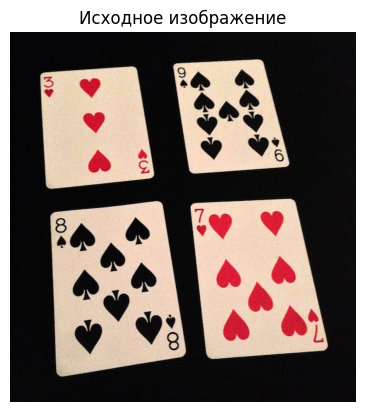

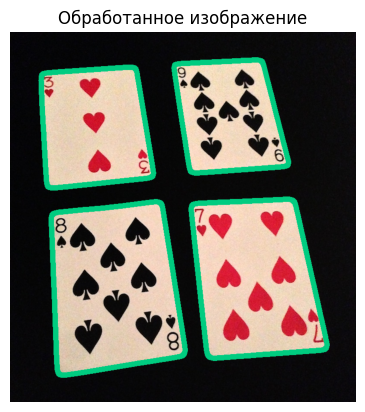

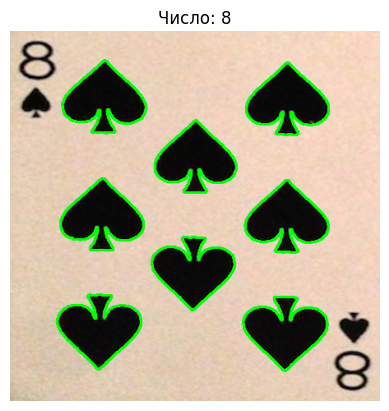

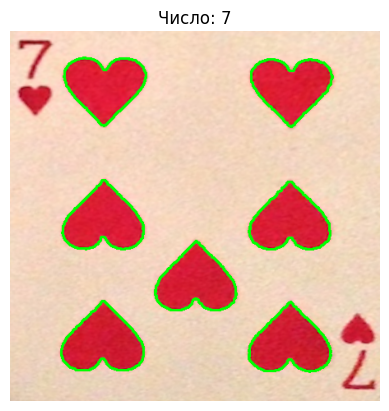

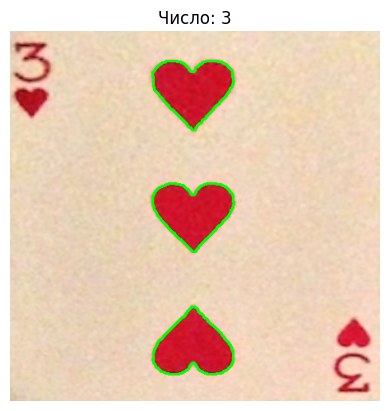

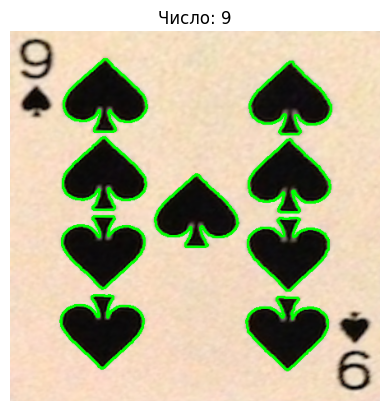

In [68]:
identify_cards(4, img)

# ДЗ №2
Подумайте, что нужно изменить, чтобы код сработал для этого изображения:
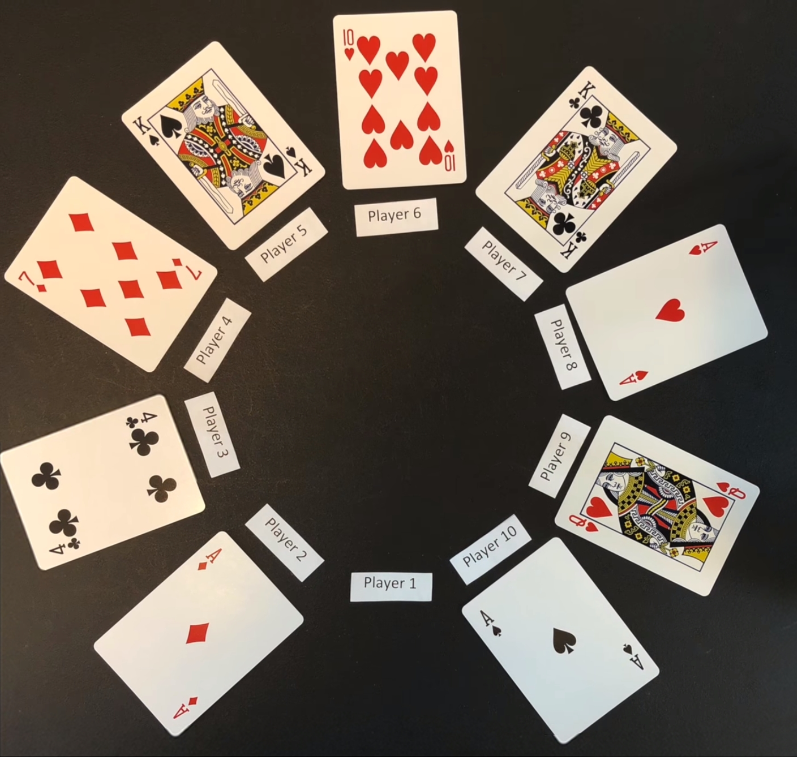

см. функцию `identify_card` _34_ строка

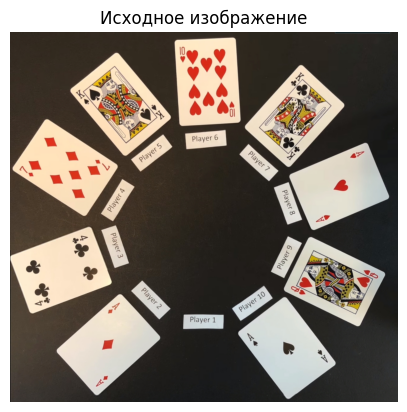

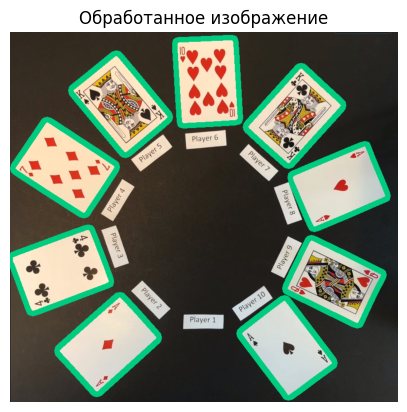

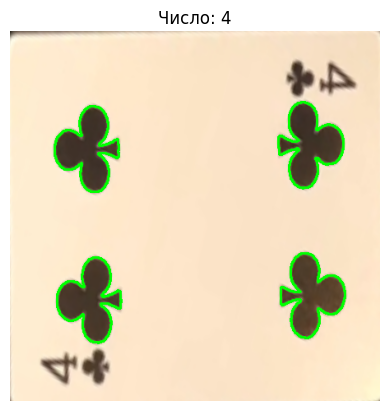

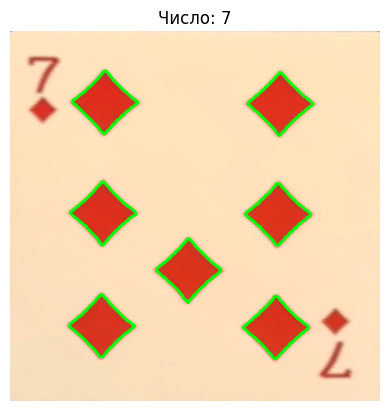

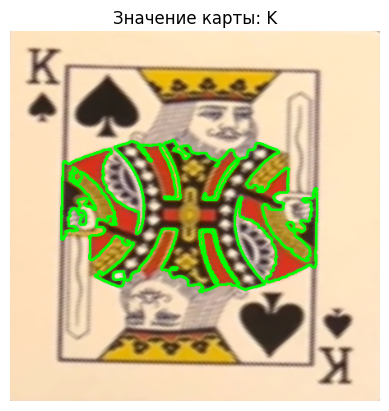

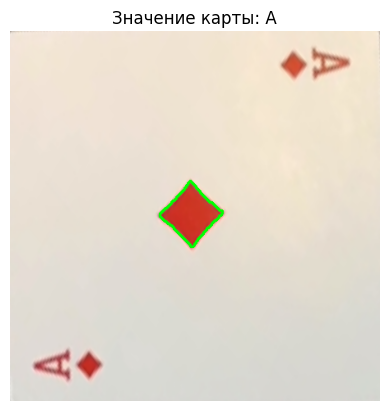

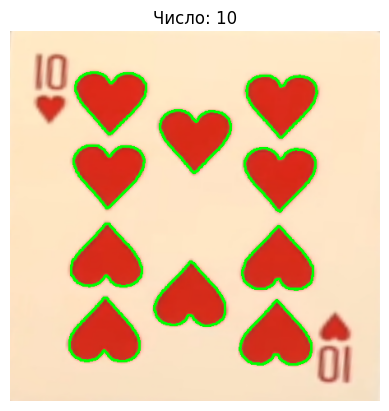

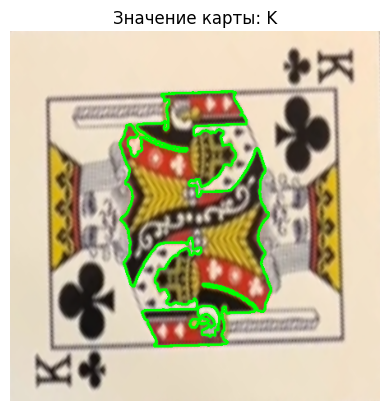

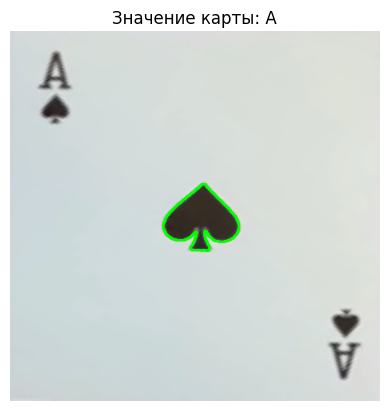

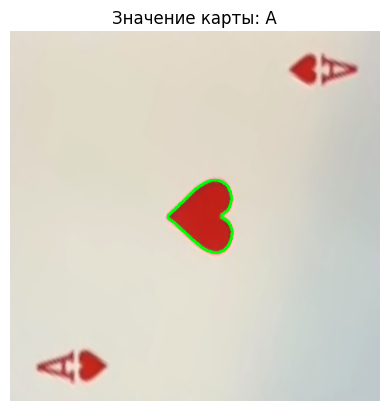

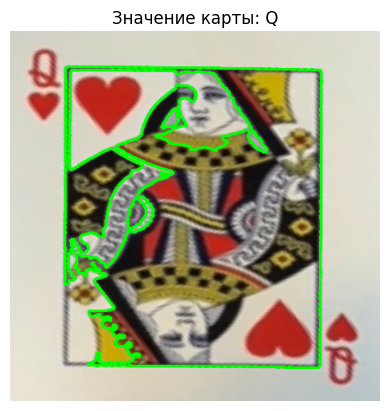

In [89]:
cards = imread('https://raw.githubusercontent.com/razrez/ml_classes/main/hw/cards.png')
identify_cards(9, cards)